In [18]:
import numpy as np 
import pandas as pd
import os
import psycopg2
import geopandas as gpd

import importlib
from Secrets import secrets
# importlib.reload(secrets)

import matplotlib.pyplot as plt

### Pull Data from a custom made AWS Database of public data
Define an engine to query AWS DB and set up the execution

In [19]:
# Define Engine
engine = psycopg2.connect(
    database="postgres",
    user=secrets.user(),
    password=secrets.password(),
    host=secrets.host(),
    port='5432'
)

cur = engine.cursor()

In [17]:
cur.execute("""

SELECT 
    *

from prices

limit 5;




""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result

,price,date,postcode,type,new,duration,locality,town,district,date_1st,...,criminal_damage,drugs,other,robbery,theft,violence,cases_total,brn,address,year
0,563950.0,2010-07-19,SW8 4RU,T,N,F,None,LONDON,LAMBETH,2010-07-01,...,16.0,12.0,0.0,37.0,75.0,41.0,181.0,3.848867e+09,THORPARCH ROAD 26,2010.0
1,322000.0,2010-03-01,SM1 3LQ,S,N,F,None,SUTTON,SUTTON,2010-03-01,...,23.0,4.0,0.0,8.0,25.0,10.0,70.0,8.938709e+09,OAK CLOSE 12,2010.0
2,444354.0,2010-09-21,E14 7FP,F,Y,L,None,LONDON,TOWER HAMLETS,2010-09-01,...,20.0,18.0,0.0,16.0,41.0,37.0,132.0,8.271874e+09,FRANCES WHARF HARLEY HOUSE 11 704,2010.0
3,132500.0,2010-04-09,NW10 8NU,F,N,L,None,LONDON,BRENT,2010-04-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.801708e+09,MORDAUNT ROAD 12B,2010.0
4,399950.0,2010-03-16,SW9 8AF,T,N,F,None,LONDON,LAMBETH,2010-03-01,...,9.0,25.0,2.0,31.0,60.0,29.0,156.0,6.382435e+08,PULROSS ROAD 41,2010.0


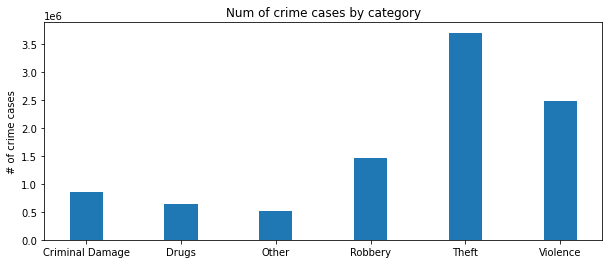

In [20]:
fig, ax = plt.subplots(figsize = (10, 4))

df = result.groupby("cat_group")["sum"].sum().reset_index()
width = 0.35
labels = df["cat_group"].to_list()
x = np.arange(len(labels))
y = df["sum"].to_list()

ax.bar(x, y, width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# of crime cases')
ax.set_title('Num of crime cases by category')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.show()

In [ ]:
cur.execute("""

select * from geo limit 5;


""")
rows = cur.fetchall()
result = pd.DataFrame(rows, columns = [desc[0] for desc in cur.description])
result

In [20]:


sql = """

select g.lsoa, g.lsoa_name, g.geometry, avg(p.price)
from geo as g
left join prices2 as p
on p.lsoa = g.lsoa
group by g.lsoa, g.geometry, g.lsoa_name;

"""

gdf = gpd.read_postgis(sql, engine, geom_col='geometry') 
gdf

,lsoa,lsoa_name,geometry,avg
0,E01004412,Waltham Forest 015A,"POLYGON ((537860.816 189145.369, 537905.112 18...",262241.237349
1,E01003435,Merton 014E,"POLYGON ((528734.439 168833.422, 528956.432 16...",214510.526730
2,E01001925,Hammersmith and Fulham 025A,"POLYGON ((525694.651 176397.904, 525706.501 17...",989160.753902
3,E01003868,Richmond upon Thames 007B,"POLYGON ((516754.999 174347.000, 516818.698 17...",425224.617481
4,E01002608,Hounslow 028A,"POLYGON ((512003.000 171946.444, 511991.462 17...",208673.230337
...,...,...,...,...
4830,E01004449,Waltham Forest 018E,"POLYGON ((536911.470 188320.534, 536901.336 18...",192131.314721
4831,E01003950,Southwark 032B,"POLYGON ((534453.263 173952.999, 534526.349 17...",251287.099812
4832,E01004410,Waltham Forest 013B,"POLYGON ((537920.381 189571.503, 537836.610 18...",246760.345840
4833,E01002716,Islington 014A,"POLYGON ((532740.664 184817.607, 532890.029 18...",285486.203922


In [37]:
gdf[gdf.avg.isna()]

,lsoa,lsoa_name,geometry,avg
4,E01002608,Hounslow 028A,"POLYGON ((512003.000 171946.444, 511991.462 17...",NaN
12,E01002370,Havering 028C,"POLYGON ((552340.879 183213.927, 552799.757 18...",NaN
15,E01004004,Southwark 023C,"POLYGON ((535272.030 177008.813, 535297.517 17...",NaN
16,E01003947,Southwark 033C,"POLYGON ((533606.494 172274.543, 533648.410 17...",NaN
17,E01004599,Wandsworth 025E,"POLYGON ((525110.917 173022.766, 525190.784 17...",NaN
...,...,...,...,...
4819,E01001662,Greenwich 037A,"POLYGON ((539552.478 178604.042, 539533.000 17...",NaN
4820,E01001840,Hackney 022B,"POLYGON ((535262.024 184382.712, 535374.145 18...",NaN
4823,E01001163,Croydon 002E,"POLYGON ((532439.238 171017.796, 532501.048 17...",NaN
4831,E01003950,Southwark 032B,"POLYGON ((534453.263 173952.999, 534526.349 17...",NaN


In [21]:
# # Define folder
# path_folder = r'/home/elena/Desktop/Dropbox/kabachok/Data Science Datasets/Real Estate London'
# col_names = ["id", "price", "date", "postcode", "type", "new?", "duration", "PAON", "SAON", "street", \
#             "locality", "town", "district", "county", "ppd", "status"]

# path = path_folder + "/Data/df_pp_ln.csv"
# df_pp = pd.read_csv( '{}/pp-complete.csv'.format(path_folder), header=0, names=col_names)

# df_map = pd.read_csv( '{}/Data_raw/london_postcodes-ons-postcodes-directory-nov2020.csv'.format(path_folder))
# df_map = df_map[["pcd", "lat", "long", "lsoa11"]]
# df_map.head()

In [22]:
# set(df_map["pcd"].unique()).difference(set( df_pp["postcode"].unique()))

In [8]:
len(gdf.lsoa.unique())

4835

In [13]:
len(df_pp["postcode"].unique())

1266279

In [12]:
df_pp.columns

Index(['id', 'price', 'date', 'postcode', 'type', 'new?', 'duration', 'PAON',
       'SAON', 'street', 'locality', 'town', 'district', 'county', 'ppd',
       'status'],
      dtype='object')

/home/elena/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:373: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


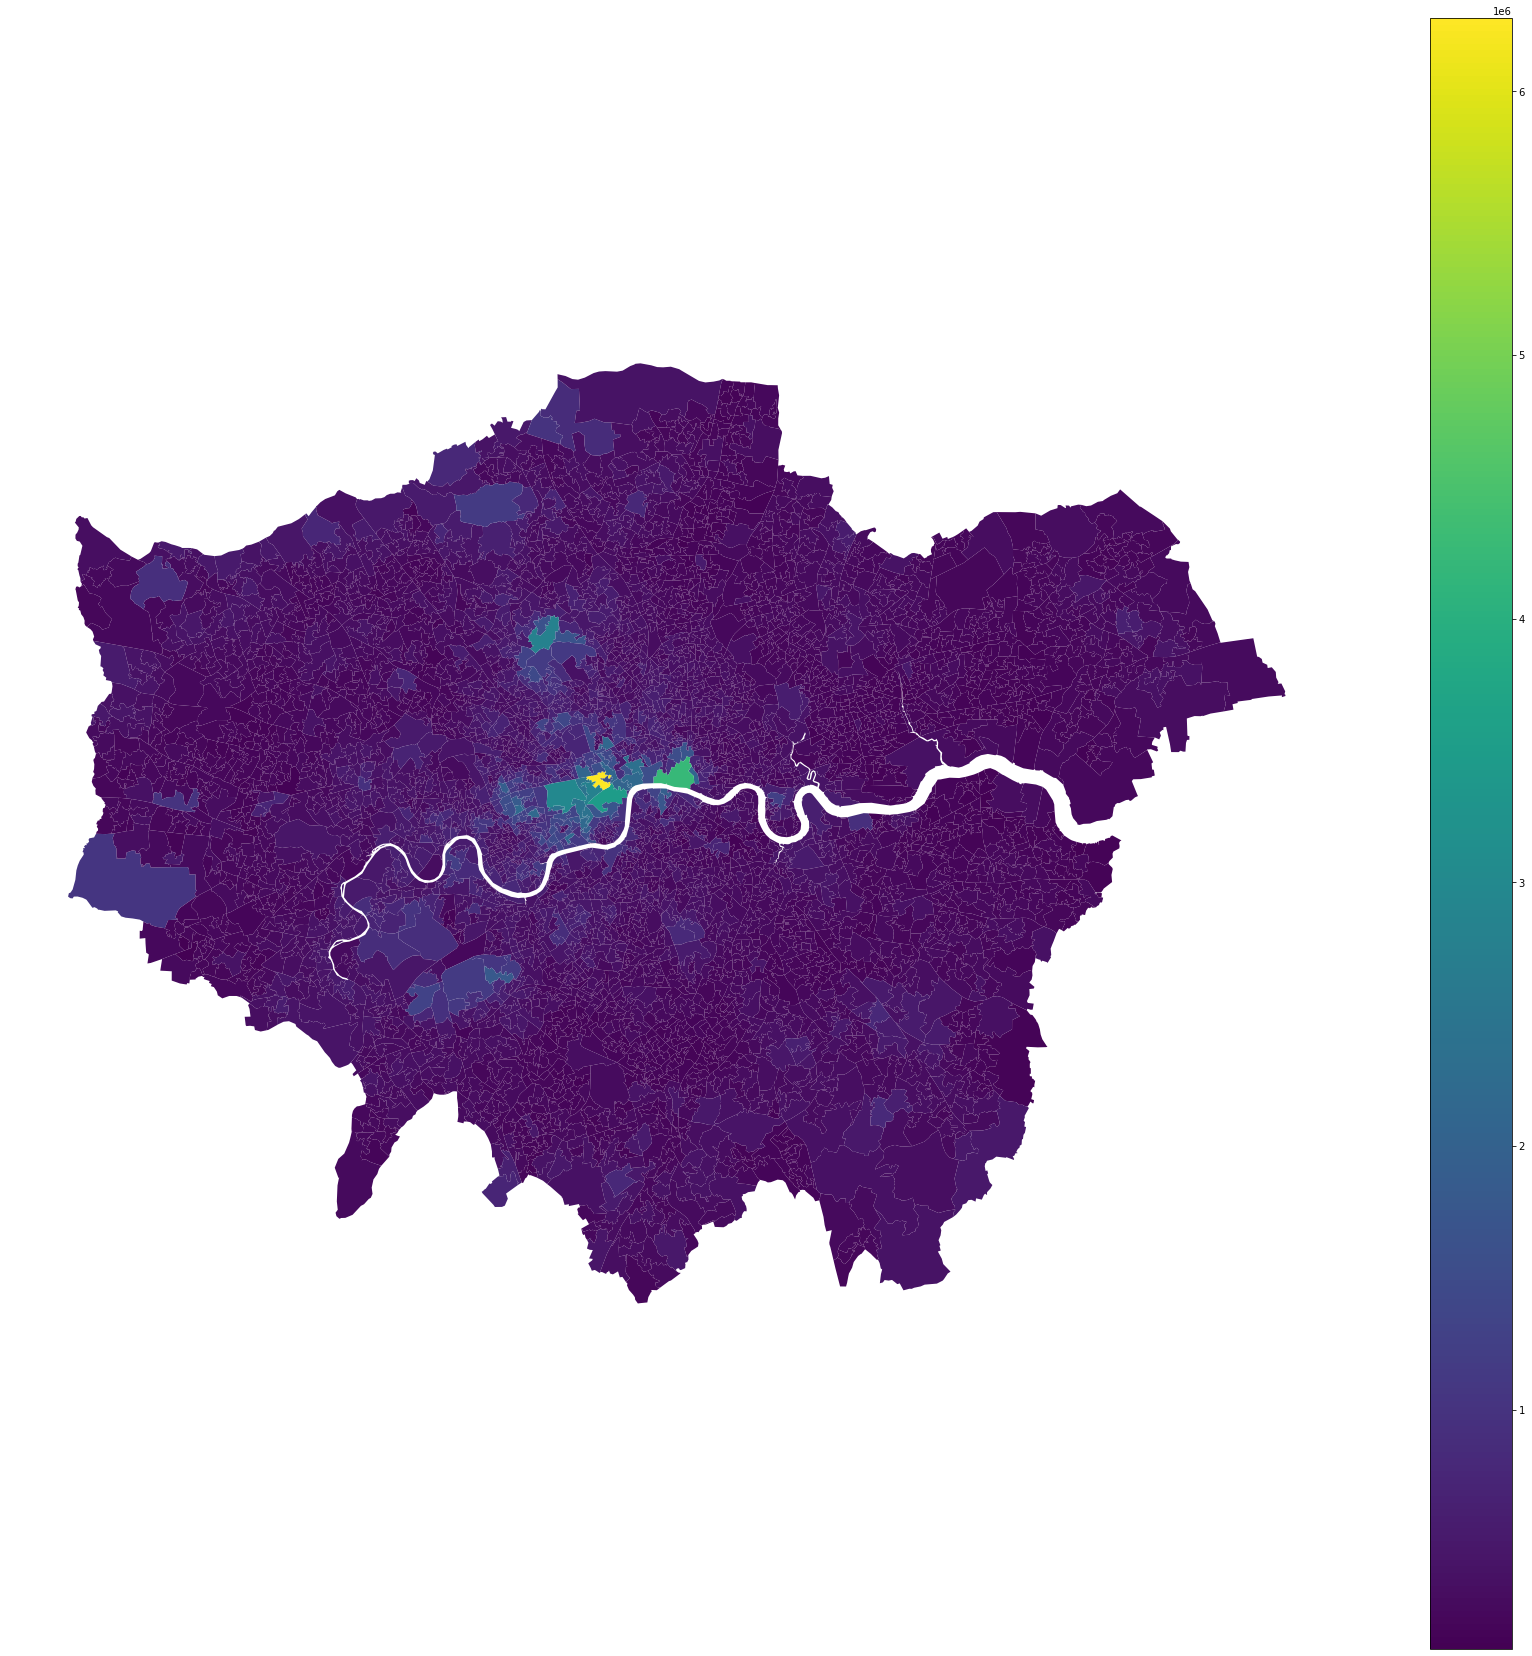

In [23]:
fig, ax = plt.subplots(figsize=(30, 30))
ax.axis('off')
gdf.plot(ax = ax, column="avg", \
         legend=True, \
         missing_kwds={
            "color": "lightgrey",
            "edgecolor": "red",
            "hatch": "///",
            "label": "Missing values",},
        )

plt.show()

In [8]:
gdf

,lsoa,lsoa_name,rg,rg_name,no_of_res,pop_den,geometry
0,E01000001,City of London 001A,E12000007,City of London,1465.0,112.9,"POLYGON ((532105.092 182011.230, 532162.491 18..."
1,E01000002,City of London 001B,E12000007,City of London,1436.0,62.9,"POLYGON ((532746.813 181786.891, 532671.688 18..."
2,E01000003,City of London 001C,E12000007,City of London,1346.0,227.7,"POLYGON ((532135.145 182198.119, 532158.250 18..."
3,E01000005,City of London 001E,E12000007,City of London,985.0,52.0,"POLYGON ((533807.946 180767.770, 533649.063 18..."
4,E01000006,Barking and Dagenham 016A,E12000007,Barking and Dagenham,1703.0,116.2,"POLYGON ((545122.049 184314.931, 545271.917 18..."
